In [2]:
# from anokas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm

image_size = (150,150)

df_train = pd.read_csv('../data/train.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

Using Theano backend.


In [27]:
x_train = []
y_train = []


for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, image_size))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [05:13<00:00, 129.21it/s]


(35000, 150, 150, 3)
(35000, 17)


In [28]:
import os

x_test = []
def load_test_images():
    file_names = os.listdir('../data/test-jpg')
    test_images = [name.split('.')[0] for name in file_names]
    for f in tqdm(test_images, miniters=1000):
        img = cv2.imread('../data/test-jpg/{}.jpg'.format(f))
        x_test.append(cv2.resize(img, image_size))
    return test_images, x_test   

test_images, x_test = load_test_images()
x_test = np.array(x_test, np.float16) / 255.

print('x_test shape:      {}'.format(x_test.shape))

100%|██████████| 40669/40669 [25:29<00:00, 91.52it/s]    


x_test shape:      (40669, 150, 150, 3)


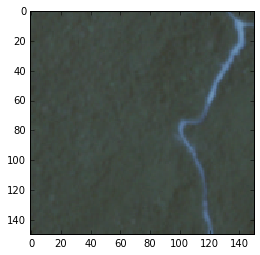

In [18]:
from matplotlib import pyplot as plt
plt.imshow(x_train[556], interpolation='nearest')
plt.show()

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

split = 35000

input_shape = (150,150,3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(17))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
              
model.fit(x_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(x_valid, y_valid))

Train on 35000 samples, validate on 0 samples
Epoch 1/4
35000/35000 [==============================] - 1123s - loss: 0.2852 - acc: 0.8899  
Epoch 2/4
35000/35000 [==============================] - 1041s - loss: 0.2210 - acc: 0.9145  
Epoch 3/4
35000/35000 [==============================] - 1034s - loss: 0.2074 - acc: 0.9182  
Epoch 4/4
35000/35000 [==============================] - 1035s - loss: 0.1984 - acc: 0.9216  


In [33]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_valid, y_valid),
         initial_epoch = 6)

Train on 35000 samples, validate on 5479 samples
Epoch 7/12
35000/35000 [==============================] - 1113s - loss: 0.1864 - acc: 0.9274 - val_loss: 0.1674 - val_acc: 0.9334
Epoch 8/12
35000/35000 [==============================] - 1118s - loss: 0.1818 - acc: 0.9293 - val_loss: 0.1683 - val_acc: 0.9334
Epoch 9/12
35000/35000 [==============================] - 1108s - loss: 0.1765 - acc: 0.9312 - val_loss: 0.1617 - val_acc: 0.9367
Epoch 10/12
35000/35000 [==============================] - 1448s - loss: 0.1725 - acc: 0.9331 - val_loss: 0.1606 - val_acc: 0.9355
Epoch 11/12
35000/35000 [==============================] - 1085s - loss: 0.1683 - acc: 0.9341 - val_loss: 0.1513 - val_acc: 0.9411
Epoch 12/12
35000/35000 [==============================] - 1068s - loss: 0.1659 - acc: 0.9349 - val_loss: 0.1496 - val_acc: 0.9407


In [37]:
# Currently using this cNN
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# best attempt so far 0.839 (ankora simple keras)
# next best attempt 0.863 (keras blog link above)

#print(x_train)

from sklearn.metrics import fbeta_score

p_valid = model.predict(x_valid, batch_size=128)
#print(y_valid)
#print(p_valid)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.862960810105


In [38]:
# create submission

p_test = model.predict(x_test, batch_size=128)

In [39]:
def create_submission_file(test_names, p_test, threshold):
    p_test_threshold = p_test > threshold
    
    return p_test_threshold
    
p_test_threshold = create_submission_file(test_images, p_test, 0.2)

print(x_test.shape)
print(p_test.shape)
print(p_test_threshold.shape)

p_tags = []
for p_single in p_test_threshold:
    p_tags.append(" ".join([inv_label_map[i] for i, tag_pred in enumerate(p_single) if tag_pred == 1]))
    
submission_df = pd.DataFrame({'image_name': test_images})
submission_df['tags'] = p_tags

submission_df.head(10)

(40669, 150, 150, 3)
(40669, 17)
(40669, 17)


,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_10,primary partly_cloudy
3,test_100,primary road cultivation agriculture clear wat...
4,test_1000,primary road cultivation agriculture clear water
5,test_10000,primary clear
6,test_10001,primary agriculture partly_cloudy
7,test_10002,primary cloudy clear
8,test_10003,primary road cloudy agriculture partly_cloudy ...
9,test_10004,primary clear


In [40]:
submission_df.to_csv('../submissions/test_submission_3.csv', index=False)

In [43]:
import h5py
model.save('../models/keras_blog.h5')

ImportError: `save_model` requires h5py.